In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.stats import poisson
from hmmBaumWelch import BaumWelch, PriorDistributionArrays

### Synthesize time series data from two probability distributions

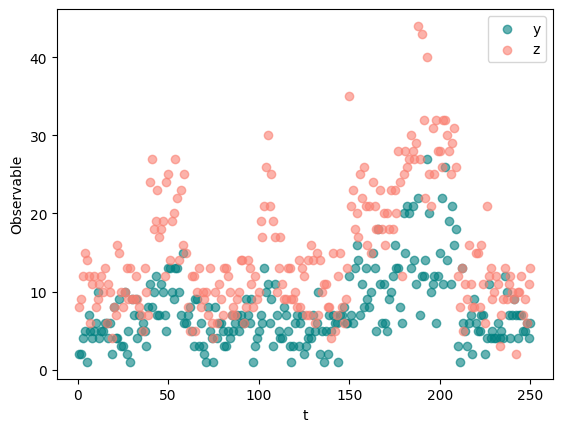

In [2]:
# create some synthetic data from Poisson distributions
np.random.seed(1)

mu_scales = [1.0, 2.0, 3.0]
mu_y = 5
mu_z = 10

x = [x for x in range(1,251)]
y = []
z = []
for xi in x:

    if ((xi>=40) and (xi<60)) or ((xi>100) and (xi<110)):
        yi = poisson.rvs(mu_y * mu_scales[1])
        zi = poisson.rvs(mu_z * mu_scales[1])
    elif ((xi>=150) and (xi<=180)):
        yi = poisson.rvs(mu_y * mu_scales[1])
        zi = poisson.rvs(mu_z * mu_scales[1])
    elif ((xi>180) and (xi<210)):
        yi = poisson.rvs(mu_y * mu_scales[2])
        zi = poisson.rvs(mu_z * mu_scales[2])
    else:
        yi = poisson.rvs(mu_y * mu_scales[0])
        zi = poisson.rvs(mu_z * mu_scales[0])

    y.append(yi)
    z.append(zi)

df = pd.DataFrame(
    data={
        'x': x, 
        'y': y,
        'z': z,
        })

plt.scatter(df['x'],df['y'], color='teal', label='y', alpha=0.6)
plt.scatter(df['x'],df['z'], color='salmon', label='z', alpha=0.6)
plt.xlabel('t')
plt.ylabel('Observable')
plt.legend()
plt.show()

### One observed variable and two hidden state

1. Make the priors (and plot)

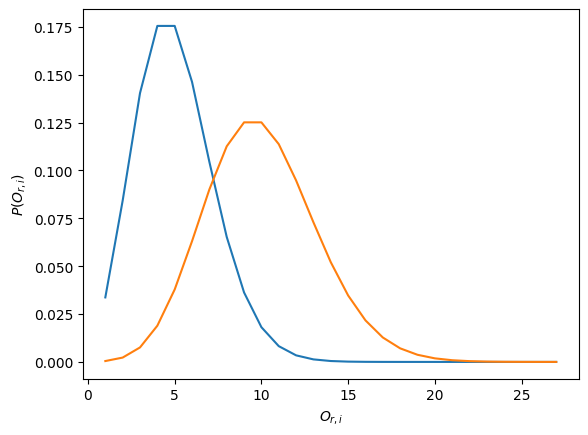

In [3]:
# instantiate the priors object
prior = PriorDistributionArrays(df)

# save the priors of a given variable, and for each hidden state, in a list
B_arrays_list = []
for mu_scale in [1.0, 2.0] :
    B_arrays_list.append(prior.poisson_distribution('y', mu_y*mu_scale))

# concatenate all priors, for a given variable, into one array 
B = PriorDistributionArrays.concatenate_B_array(B_arrays_list)

# plot
N, K, L = B.shape
for Ni in range(N):
    plt.plot(B[Ni,:,0], B[Ni,:,1])

plt.xlabel('$O_{r,i}$')
plt.ylabel('$P(O_{r,i})$')
plt.show()

2. Make the BaumWelch model and perform HMM inference

In [4]:
# create the BaumWelch (HMM) object
HMM = BaumWelch(
                    Z = {0,1},
                    O_list = [df['y'].tolist()],
                    pi=[0.5, 0.5],
                    A=np.array([[0.8, 0.2], 
                                [0.2, 0.8]]),
                    B_list=[B],
                )

# perform expectation maximisation
HMM.baumwelch_expectationMaximisation(iter=30, update_pi=True, update_A=True, update_B=False)

# inference
_, _, Z_inference, gamma_meanR = HMM.Z_state_probs_inference()

Early stopping converged on iteration 8.


3. Plot results

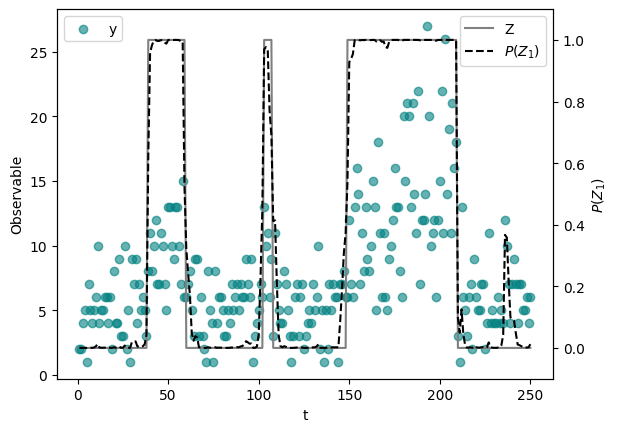

In [5]:
# Creating the main plot
fig, ax1 = plt.subplots()

# Plotting the bar chart
ax1.scatter(df['x'],df['y'], color='teal', alpha=0.6, label='y')

ax1.set_xlabel("t")
ax1.set_ylabel('Observable')

plt.legend(loc='upper left')

# Creating a secondary y-axis on the right side
ax2 = ax1.twinx()

ax2.plot(df['x'],Z_inference[0,:], color='grey', linestyle='-', label='Z')
ax2.plot(df['x'],gamma_meanR[1,:], color='black', linestyle='--', label='$P(Z_{1})$')
ax2.set_ylabel('$P(Z_{1})$', color='black')
ax2.set_ylim(-0.1,1.1)
plt.legend(loc='upper right')
plt.show()

### Two observed variables and three hidden states

1. Priors

In [6]:
# instantiate the priors object
prior = PriorDistributionArrays(df)

# need a prior for each observable and each hidden state
B_observables_list = []
for observable, mu in zip(['y', 'z'], [mu_y, mu_z]):
    B_observable_arrays = []
    for mu_scale in mu_scales:
        B_observable_arrays.append(prior.poisson_distribution(observable, mu*mu_scale))

    # concatenate all priors, for a given variable, into one array 
    B = PriorDistributionArrays.concatenate_B_array(B_observable_arrays)

    B_observables_list.append(B)

2. BaumWelch expectation maximisation and inference

In [8]:
# create the BaumWelch (HMM) object
HMM = BaumWelch(
                    Z = {0,1,2},
                    O_list = [df['y'].tolist(), df['z'].tolist()],
                    pi=[0.34, 0.33, 0.33],
                    A=np.array([[0.6, 0.2, 0.2], 
                                [0.2, 0.6, 0.2],
                                [0.2, 0.2, 0.6], 
                                ]),
                    B_list=B_observables_list,
                )

# perform expectation maximisation
HMM.baumwelch_expectationMaximisation(iter=30, update_pi=True, update_A=True, update_B=False)

# inference
_, _, Z_inference, gamma_meanR = HMM.Z_state_probs_inference()

Early stopping converged on iteration 10.


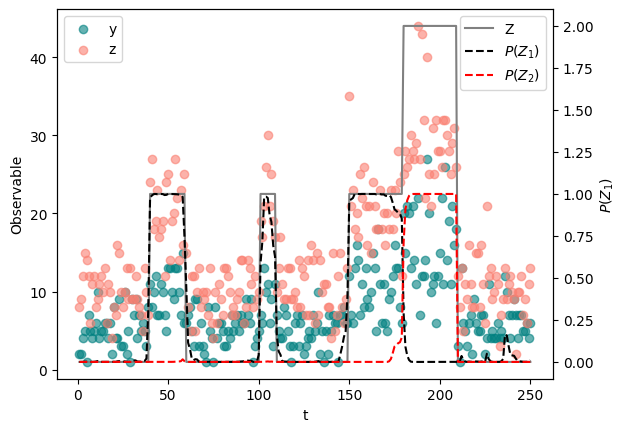

In [13]:
# Creating the main plot
fig, ax1 = plt.subplots()

# Plotting the bar chart
ax1.scatter(df['x'],df['y'], color='teal', alpha=0.6, label='y')
ax1.scatter(df['x'],df['z'], color='salmon', alpha=0.6, label='z')

ax1.set_xlabel("t")
ax1.set_ylabel('Observable')

plt.legend(loc='upper left')

# Creating a secondary y-axis on the right side
ax2 = ax1.twinx()

ax2.plot(df['x'],Z_inference[0,:], color='grey', linestyle='-', label='Z')
ax2.plot(df['x'],gamma_meanR[1,:], color='black', linestyle='--', label='$P(Z_{1})$')
ax2.plot(df['x'],gamma_meanR[2,:], color='red', linestyle='--', label='$P(Z_{2})$')
ax2.set_ylabel('$P(Z_{1})$', color='black')
ax2.set_ylim(-0.1,2.1)
plt.legend(loc='upper right')
plt.show()

In [ ]:
alpha_log = HMM.alpha_log

In [ ]:
alpha_log.shape

In [ ]:
alpha_log[:,-1,0]

In [ ]:
alpha_log[:,-1,:]

In [ ]:
np.average(alpha_log[:,-1,:])

In [ ]:
np.sum(alpha_log)

In [ ]:
np.exp(np.sum(alpha_log, axis=(1,2)))

In [ ]:
delta_P_alpha = 0.0001
delta_P_alpha_log = np.log(delta_P_alpha)

In [ ]:
delta_P_alpha2 = 0.00000000001
delta_P_alpha2_log = np.log(delta_P_alpha2)

In [ ]:
print(delta_P_alpha_log) 
print(delta_P_alpha2_log)

In [ ]:
delta_P_alpha2_log < delta_P_alpha_log

In [ ]:
np.log(0.000000001)

In [ ]:
-20 - 0

In [ ]:
-30 - -20

In [ ]:
0 - -20

In [ ]:
-20 - -30